## The Lottery Ticket Hypothesis

The [Lottery Ticket Hypothesis](https://arxiv.org/abs/1803.03635) is a really intriguing discovery made in 2019 by Frankle & Carbin. It states that:

> A randomly-initialized, dense neural network contains a subnetwork that is initialised such that — when trained in isolation — it can match the test accuracy of the original network after training for at most the same number of iterations.

Meaning that, once we find that subnetwork. Every other parameter in the network becomes useless.

The way authors propose to find those subnetwork is as follows:


![](imgs/LTH.png "Lottery Ticket Hypothesis")


1. Initialize the neural network
2. Train it to convergence
3. Prune the smallest magnitude weights by creating a mask $m$
4. Reinitialize the weights to their original value; i.e at iteration $0$.
5. Repeat from step 2 until reaching the desired level of sparsity.


In [ ]:
#| include: false
from fastai.vision.all import *

import torch
import torch.nn as nn

import seaborn as sns

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [ ]:
from fasterai.sparse.all import *

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64), device=device)

What we are trying to prove is that: in a neural network A, there exists a subnetwork B able to get an accuracy $a_B > a_A$, in a training time $t_B < t_A$.

Let's get the baseline for network A:

In [ ]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)

Let's save original weights 

In [ ]:
initial_weights = deepcopy(learn.model.state_dict())

In [ ]:
learn.fit(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.624942,0.559285,0.711096,00:08
1,0.554435,0.629745,0.699594,00:07
2,0.540063,0.562307,0.723951,00:07
3,0.500982,0.548926,0.704330,00:07
4,0.459079,0.565009,0.675913,00:07


We now have our accuracy $a_A$ of $79\%$ and our training time $t_A$ of $5$ epochs

To find the lottery ticket, we will perform iterative pruning but, at each pruning step we will re-initialize the remaining weights to their original values (i.e. before training).

We will restart from the same initialization to be sure to not get lucky.

In [ ]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)
learn.model.load_state_dict(initial_weights)

<All keys matched successfully>

We can pass the parameters `lth=True` to make the weights of the network reset to their original value after each pruning step, i.e. step 4) of the LTH. To empirically validate the LTH, we need to retrain the found "lottery ticket" after the pruning phase. Lottery tickets are usually found following an iterative pruning schedule. We set the `start_epoch` parameter to $5$ to begin the pruning process after $5$ epochs.

In [ ]:
schedule = Schedule(sched_iterative, start_pct=0.25)

In [ ]:
sp_cb = SparsifyCallback(50, 'weight', 'local', large_final, schedule, lth=True)

As our `iterative` schedule makes $3$ pruning steps by default, it means that we have to train our network for `start_epoch` + $3*t_B$, so $20$ epochs in order to get our LTH. After each step, the remaining weights will be reinitialized to their original value

In [ ]:
learn.fit(20, 1e-3, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.584362,0.607169,0.635995,00:07
1,0.547975,0.663318,0.719215,00:07
2,0.518505,0.544549,0.716509,00:07
3,0.472541,0.470786,0.775372,00:07
4,0.425963,0.673728,0.730717,00:07
5,0.573806,0.529624,0.723275,00:07
6,0.507284,0.458147,0.777402,00:07
7,0.447610,0.629908,0.652233,00:07
8,0.412829,0.394333,0.823410,00:07
9,0.381195,0.413377,0.815291,00:07


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [0.0]%
Sparsity at the end of epoch 3: [0.0]%
Sparsity at the end of epoch 4: [0.0]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 5: [16.67]%
Sparsity at the end of epoch 6: [16.67]%
Sparsity at the end of epoch 7: [16.67]%
Sparsity at the end of epoch 8: [16.67]%
Sparsity at the end of epoch 9: [16.67]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 10: [33.33]%
Sparsity at the end of epoch 11: [33.33]%
Sparsity at the end of epoch 12: [33.33]%
Sparsity at the end of epoch 13: [33.33]%
Sparsity at the end of epoch 14: [33.33]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 15: [50.0]%
Sparsity at the end of epoch 16: [50.0]%
Sparsity at the end of epoch 17: [50.0]%
Sparsity at the end of epoch 18: [50.0]%
Sparsity at the end of epoch 19: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 1: 50.00%
Sparsi

We indeed have a network B, whose accuracy $a_B > a_A$ in the same training time.

## Lottery Ticket Hypothesis with Rewinding

In some case, LTH fails for deeper networks, author then propose a [solution](https://arxiv.org/pdf/1903.01611.pdf), which is to rewind the weights to a more advanced iteration instead of the initialization value.

In [ ]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)
learn.model.load_state_dict(initial_weights)

<All keys matched successfully>

This can be done in fasterai by passing the `rewind_epoch` parameter, that will save the weights at that epoch, then resetting the weights accordingly.

In [ ]:
sp_cb = SparsifyCallback(50, 'weight', 'local', large_final, schedule, lth=True, rewind_epoch=1)

In [ ]:
learn.fit(20, 1e-3, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%


epoch,train_loss,valid_loss,accuracy,time
0,0.587423,0.669452,0.696211,00:07
1,0.561204,0.543574,0.705683,00:07
2,0.541044,0.515325,0.746279,00:07
3,0.502017,0.483110,0.756428,00:07
4,0.459558,0.570272,0.736807,00:07
5,0.549915,0.579451,0.720568,00:07
6,0.470164,0.461384,0.799729,00:07
7,0.438228,0.657783,0.612314,00:07
8,0.388232,0.643327,0.659675,00:07
9,0.349985,0.447483,0.783491,00:07


Sparsity at the end of epoch 0: [0.0]%
Saving Weights at epoch 1
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [0.0]%
Sparsity at the end of epoch 3: [0.0]%
Sparsity at the end of epoch 4: [0.0]%
Resetting Weights to their epoch 1 values
Sparsity at the end of epoch 5: [16.67]%
Sparsity at the end of epoch 6: [16.67]%
Sparsity at the end of epoch 7: [16.67]%
Sparsity at the end of epoch 8: [16.67]%
Sparsity at the end of epoch 9: [16.67]%
Resetting Weights to their epoch 1 values
Sparsity at the end of epoch 10: [33.33]%
Sparsity at the end of epoch 11: [33.33]%
Sparsity at the end of epoch 12: [33.33]%
Sparsity at the end of epoch 13: [33.33]%
Sparsity at the end of epoch 14: [33.33]%
Resetting Weights to their epoch 1 values
Sparsity at the end of epoch 15: [50.0]%
Sparsity at the end of epoch 16: [50.0]%
Sparsity at the end of epoch 17: [50.0]%
Sparsity at the end of epoch 18: [50.0]%
Sparsity at the end of epoch 19: [50.0]%
Final Sparsity: [50.0]%
Sparsity 

## Super-Masks

Researchers from Uber AI [investigated](https://arxiv.org/pdf/1905.01067.pdf) the LTH and found the existence of what they call "Super-Masks", i.e. masks that, applied on a untrained neural network, allows to reach better-than-random results.

In [ ]:
learn = Learner(dls, resnet18(num_classes=2), metrics=accuracy)
learn.model.load_state_dict(initial_weights)

<All keys matched successfully>

To find supermasks, authors perform the LTH method then apply the mask on the original, untrained network. In fasterai, you can pass the parameter `reset_end=True`, which will reset the weights to their original value at the end of the training, but keeping the pruned weights (i.e. the mask) unchanged.

In [ ]:
sp_cb = SparsifyCallback(50, 'weight', 'local', large_final, schedule, lth=True, reset_end=True)

In [ ]:
#| include: false
schedule.plot(50)

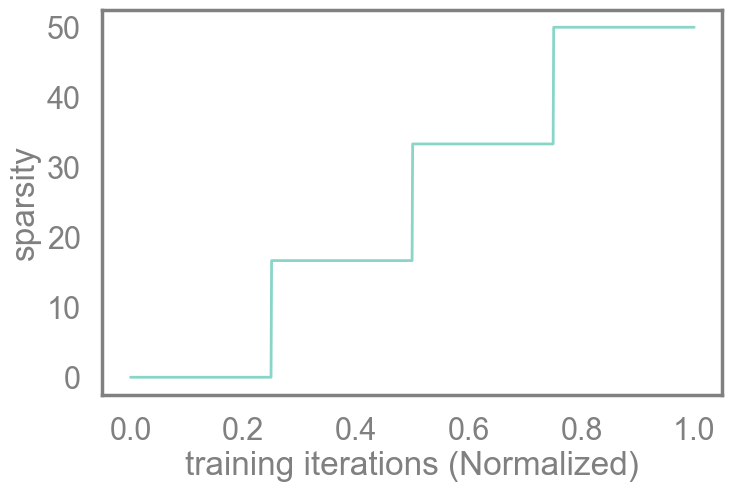

In [ ]:
#| include: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)
prune = np.linspace(0, 1, 1000)
sps = [schedule([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

In [ ]:
learn.fit(20, 1e-3, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.585188,0.581024,0.709743,00:07
1,0.553269,0.772498,0.702300,00:07
2,0.513219,0.505785,0.736130,00:07
3,0.483751,0.452862,0.782815,00:07
4,0.437997,0.509538,0.740866,00:07
5,0.547269,0.488490,0.763870,00:07
6,0.505039,0.517426,0.734100,00:07
7,0.452737,0.520701,0.743572,00:07
8,0.422814,0.447591,0.795670,00:07
9,0.388168,0.444148,0.784168,00:07


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [0.0]%
Sparsity at the end of epoch 3: [0.0]%
Sparsity at the end of epoch 4: [0.0]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 5: [16.67]%
Sparsity at the end of epoch 6: [16.67]%
Sparsity at the end of epoch 7: [16.67]%
Sparsity at the end of epoch 8: [16.67]%
Sparsity at the end of epoch 9: [16.67]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 10: [33.33]%
Sparsity at the end of epoch 11: [33.33]%
Sparsity at the end of epoch 12: [33.33]%
Sparsity at the end of epoch 13: [33.33]%
Sparsity at the end of epoch 14: [33.33]%
Resetting Weights to their epoch 0 values
Sparsity at the end of epoch 15: [50.0]%
Sparsity at the end of epoch 16: [50.0]%
Sparsity at the end of epoch 17: [50.0]%
Sparsity at the end of epoch 18: [50.0]%
Sparsity at the end of epoch 19: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 1: 50.00%
Sparsi

In [ ]:
learn.validate()

(#2) [0.6950991749763489,0.46008118987083435]